Overall video duration: 0:05:02.998000
0.5 minutes processed
1.0 minutes processed
1.5 minutes processed
2.0 minutes processed
2.5 minutes processed
3.0 minutes processed
3.5 minutes processed
4.0 minutes processed
4.5 minutes processed
4.9911111111111115 minutes processed


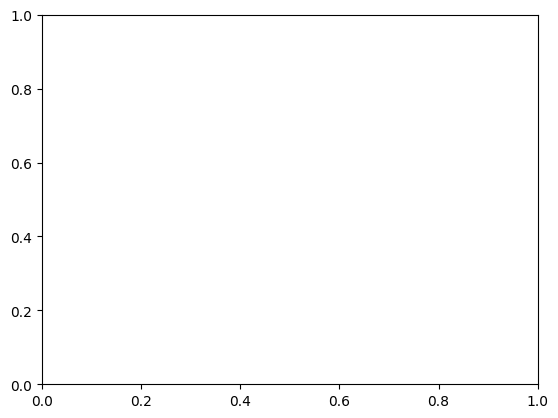

In [24]:
import ffmpegio
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
from mediapipe_utils import *
from synchronization_utils import *

def extract_face_vector(path_bag, output_folder):
    """
    Extracts a vector representing face movement over time from a realsense .bag file.

    This function processes a the .bag file specified by `path_bag` to detect and track
    a bellow nose to forehead vector using a Mediapipe face model.

    Parameters:
    - path_bag (str): Path to the .bag file containing the realsense data.
    - mediapipe_face_model_file (str): Path to the Mediapipe face model file for face detection.

    Returns:
    - numpy.ndarray: An array of shape (frames, 3)
      Each row contains the x, y, z vector direction relative to another facial point.

    Notes:
    - The function assumes a video resolution of 640x480.
    - RealSense SDK is used for video processing, and playback is adjusted to process frames
      as needed, avoiding real-time constraints.
    - Frames where the face is not detected are handled by repeating the last valid detection.
    - The function visualizes face landmarks and their movements in real-time during processing.
    - Press 'q' to quit the visualization and processing early.
    - The function smooths the movement data for visualization purposes.

    Raises:
    - Exception: If there are issues initializing the video pipeline or processing frames.
    """

    img_height = 480
    img_width = 640

    pipeline = rs.pipeline()
    config = rs.config()
    rs.config.enable_device_from_file(config, path_bag)

    config.enable_stream(rs.stream.depth, img_width, img_height, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, img_width, img_height, rs.format.bgr8, 30)

    profile = pipeline.start(config)
    playback = profile.get_device().as_playback()
    
    # we want to set_real_time to False, so that we can process the frames as slowly as necessary.
    # However, there are errors reading it at the beginning and at the end (hopefully not in the middle)
    # when we set it to False right at the beginning. Therefore, we set it to True at the beginning 
    # and then to False after the first frame is read. The end is handled differently - with reading the frames
    # up to the duration of the video - 1s (to be sure that we don't miss the last frame)
    playback.set_real_time(True)

    first_frame = True
    prev_ts = -1
    max_frame_nb = 0
    frame_nb = -1

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) 
    ts = 0

    time_series = []
    frames_list = []
    duration = playback.get_duration().total_seconds() * 1000
    print(f"Overall video duration: {playback.get_duration()}")
    # playback.seek(datetime.timedelta(seconds=73*4))
    try:
        while True:
            try:
                frames = pipeline.wait_for_frames()
            except:
                print("READING ERROR")
                playback.set_real_time(True)


            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()

            playback.set_real_time(False)


            # skipped frame by RealSense
            if not depth_frame or not color_frame:
                print("SKIPPED FRAME! HANDLE IT!")
                continue

            last_frame_nb = frame_nb
            frame_nb = color_frame.get_frame_number()

            # finish of the file (no more new frames)
            if frame_nb < max_frame_nb:
                break

            max_frame_nb = frame_nb

            ts = frames.get_timestamp()


            depth_image_rs = np.asanyarray(depth_frame.get_data())
            color_image_rs = np.asanyarray(color_frame.get_data()) # returns RGB!

            frames_list.append(cv2.cvtColor(color_image_rs, cv2.COLOR_BGR2RGB))

            if first_frame: 
                t0 = ts
                first_frame = False
            
            # the video is at the end (without the last second) so we kill the reading
            # (there was an error with the last frame, this handles it)
            if ts - t0 + 1000 > duration:
                break

            if prev_ts >= int(ts-t0):
                # doubled frame or some other error in ordering (we don't include the frame
                # as we don't want it multiple times)
                continue

            
            prev_prev_ts = prev_ts
            prev_ts = int(ts-t0)

            if prev_ts - prev_prev_ts > 2*int(1000/30) - 10:
                print(f"Skipped frame. Previous ts: {prev_ts}, difference {prev_ts - prev_prev_ts}")

            time_series.append([prev_ts])

            ch = cv2.waitKey(1)
            if ch==113: #q pressed
                break

            if len(time_series) % (30*30) == 0:
                frames_list = np.stack(frames_list)
                ffmpegio.video.write(os.path.join(output_folder, f'v1_p{len(time_series) / (30*30)}.mp4'), 30, frames_list, show_log=True, loglevel="warning")
                print(f"{len(time_series) / (30*30) / 2} minutes processed")
                frames_list = []

            t = ts - t0

    finally:
        frames_list = np.stack(frames_list)
        ffmpegio.video.write(os.path.join(output_folder, f'v1_p{len(time_series) / (30*30)}.mp4'), 30, frames_list, show_log=True, loglevel="warning")
        print(f"{len(time_series) / (30*30) / 2} minutes processed")
        frames_list = []
        pipeline.stop()
        cv2.destroyAllWindows()
        # frames_list = np.stack(frames_list)
    
    # return frames_list

path_bag = '/home/mpicek/repos/master_project/test_data/corresponding/bags/2023_11_13/realsense/cam0_911222060374_record_13_11_2023_1337_20.bag'
output_folder = '/home/mpicek/repos/master_project/test_data/corresponding/bags/2023_11_13/realsense/'

tmp_folder = os.path.join(output_folder, 'tmp')
if not os.path.exists(tmp_folder):
    os.makedirs(tmp_folder)

extract_face_vector(path_bag, tmp_folder)

# List all mp4 files in the current directory alphabetically
mp4_files = sorted([os.path.join(tmp_folder, file) for file in os.listdir(tmp_folder) if file.endswith('.mp4')])

# Create a temporary file listing all mp4 files
with open('file_list.txt', 'w') as file_list:
    for mp4_file in mp4_files:
        file_list.write(f"file '{mp4_file}'\n")


# Concatenate mp4 files using ffmpeg
output_file_name = os.path.join(output_folder, os.path.basename(path_bag)[:-4] + '.mp4')
print(f"The video is being saved into: {output_file_name}")
subprocess.run(['ffmpeg', '-f', 'concat', '-safe', '0', '-i', 'file_list.txt', '-c', 'copy', output_file_name, '-loglevel', 'error'])

# Remove the temporary file
os.remove('file_list.txt')

# Delete the original mp4 files in the tmp folder
shutil.rmtree(tmp_folder)